In [ ]:
!python --version

Python 3.9.13


In [ ]:
!pip install torch

In [ ]:
!pip install torchvision

In [ ]:
!pip install torch-summary

In [ ]:
!pip install tqdm

In [ ]:
!pip install matplotlib

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.utils.data as data
import torch.nn.init as init

import torchvision
import torchvision.transforms as transforms

import argparse
import os
import sys
import time
import math
from tqdm import tqdm
from pickle import dump, load
from matplotlib.pylab import plt
from numpy import arange

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
start_epoch = 0
best_acc = 0

In [ ]:
# Data transforms for train and test sets
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


In [ ]:
print('==> Preparing data..')
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

In [ ]:
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

In [ ]:
# Splitting valid set from training data
VALID_RATIO = 0.9

n_train_examples = int(len(trainset) * VALID_RATIO)
n_valid_examples = len(trainset) - n_train_examples

train_data, valid_data = data.random_split(trainset, 
                                           [n_train_examples, n_valid_examples])

In [ ]:
train_data

In [ ]:
valid_data

In [ ]:
trainset=train_data
valset = valid_data

In [ ]:
#Data Loaders
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(
    valset, batch_size=128, shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
## Model defination
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        """
        in_planes: C_in for conv1 and Sequential.Conv2d
        planes: F_i
        """
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks,  num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 32
        """
        in_planes: C_out of layer1
        """
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=1)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
            """
            in_planes becomes the output of the current layer
            """
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 8) # to be understood
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [ ]:
print('==> Building model..')
net = ResNet18()
net = net.to(device)

==> Building model..


In [ ]:
## For our model
from torchsummary import summary
summary(net, input_size=(3, 32, 32))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            864
├─BatchNorm2d: 1-2                       64
├─Sequential: 1-3                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  9,216
|    |    └─BatchNorm2d: 3-2             64
|    |    └─Conv2d: 3-3                  9,216
|    |    └─BatchNorm2d: 3-4             64
|    |    └─Sequential: 3-5              --
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  9,216
|    |    └─BatchNorm2d: 3-7             64
|    |    └─Conv2d: 3-8                  9,216
|    |    └─BatchNorm2d: 3-9             64
|    |    └─Sequential: 3-10             --
├─Sequential: 1-4                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 18,432
|    |    └─BatchNorm2d: 3-12            128
|    |    └─Conv2d: 3-13                 36,864
|    |    └─BatchNorm2d: 3-14            128
|   

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            864
├─BatchNorm2d: 1-2                       64
├─Sequential: 1-3                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  9,216
|    |    └─BatchNorm2d: 3-2             64
|    |    └─Conv2d: 3-3                  9,216
|    |    └─BatchNorm2d: 3-4             64
|    |    └─Sequential: 3-5              --
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  9,216
|    |    └─BatchNorm2d: 3-7             64
|    |    └─Conv2d: 3-8                  9,216
|    |    └─BatchNorm2d: 3-9             64
|    |    └─Sequential: 3-10             --
├─Sequential: 1-4                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 18,432
|    |    └─BatchNorm2d: 3-12            128
|    |    └─Conv2d: 3-13                 36,864
|    |    └─BatchNorm2d: 3-14            128
|   

In [ ]:
device

'cuda'

In [ ]:
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

In [ ]:
resume = False
if resume == True:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005,
                      weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [ ]:
len(trainloader)

352

In [ ]:
train_loss_dict = {}
val_loss_dict = {}
train_acc_dict = {}
val_acc_dict = {}
test_acc_dict = {}

In [ ]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    steps = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        steps = steps+1
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        #progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        #             % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        if steps%87==0:
            print(f"Epoch:{epoch} --Progress(%):{batch_idx/len(trainloader)*100.:.2f}-- Loss:{train_loss/(batch_idx+1):.2f} -- Acc:{100.*correct/total:.2f}")



In [ ]:
# Validation function
def val(epoch):
    global best_acc
    net.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            #progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            #             % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    print(f"Epoch:{epoch} --Val Loss:{val_loss/(batch_idx+1):.2f} -- Acc:{100.*correct/total:.2f}")
    
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving the best model.')
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        
        torch.save(net.state_dict(), './checkpoint/ckpt.pth')
        best_acc = acc

In [ ]:
# Testing Function
def test(epoch):
    print("***** Begin testing *****")
    net.load_state_dict(torch.load('./checkpoint/ckpt.pth'))
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            #progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            #             % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    print(f"Epoch:{epoch} --Test Loss:{test_loss/(batch_idx+1):.2f} -- Acc:{100.*correct/total:.2f}")

In [ ]:
for epoch in range(start_epoch, start_epoch+500):
    train(epoch)
    scheduler.step()
    val(epoch)
    
test(epoch)
# Save the training loss values
with open('./train_loss.pkl', 'wb') as file:
    dump(train_loss_dict, file)
 
# Save the validation loss values
with open('./val_loss.pkl', 'wb') as file:
    dump(val_loss_dict, file)

# Save the training accuracy values
with open('./train_acc.pkl', 'wb') as file:
    dump(train_acc_dict, file)

# Save the validation accuracy values
with open('./val_acc.pkl', 'wb') as file:
    dump(val_acc_dict, file)


Epoch: 0
Epoch:0 --Progress(%):24.43-- Loss:1.73 -- Acc:35.29
Epoch:0 --Progress(%):49.15-- Loss:1.56 -- Acc:42.55
Epoch:0 --Progress(%):73.86-- Loss:1.44 -- Acc:47.53
Epoch:0 --Progress(%):98.58-- Loss:1.35 -- Acc:50.88
Epoch:0 --Val Loss:1.18 -- Acc:57.96
Saving the best model.

Epoch: 1
Epoch:1 --Progress(%):24.43-- Loss:0.97 -- Acc:64.78
Epoch:1 --Progress(%):49.15-- Loss:0.95 -- Acc:66.05
Epoch:1 --Progress(%):73.86-- Loss:0.93 -- Acc:66.89
Epoch:1 --Progress(%):98.58-- Loss:0.91 -- Acc:67.75
Epoch:1 --Val Loss:0.95 -- Acc:66.68
Saving the best model.

Epoch: 2
Epoch:2 --Progress(%):24.43-- Loss:0.77 -- Acc:72.83
Epoch:2 --Progress(%):49.15-- Loss:0.76 -- Acc:73.33
Epoch:2 --Progress(%):73.86-- Loss:0.74 -- Acc:73.94
Epoch:2 --Progress(%):98.58-- Loss:0.73 -- Acc:74.50
Epoch:2 --Val Loss:0.98 -- Acc:66.84
Saving the best model.

Epoch: 3
Epoch:3 --Progress(%):24.43-- Loss:0.66 -- Acc:77.24
Epoch:3 --Progress(%):49.15-- Loss:0.65 -- Acc:77.67
Epoch:3 --Progress(%):73.86-- Loss:0.6

Epoch:30 --Progress(%):24.43-- Loss:0.18 -- Acc:93.97
Epoch:30 --Progress(%):49.15-- Loss:0.18 -- Acc:93.75
Epoch:30 --Progress(%):73.86-- Loss:0.19 -- Acc:93.45
Epoch:30 --Progress(%):98.58-- Loss:0.19 -- Acc:93.46
Epoch:30 --Val Loss:0.43 -- Acc:86.24

Epoch: 31
Epoch:31 --Progress(%):24.43-- Loss:0.17 -- Acc:94.42
Epoch:31 --Progress(%):49.15-- Loss:0.18 -- Acc:94.01
Epoch:31 --Progress(%):73.86-- Loss:0.18 -- Acc:93.79
Epoch:31 --Progress(%):98.58-- Loss:0.19 -- Acc:93.59
Epoch:31 --Val Loss:0.42 -- Acc:86.60

Epoch: 32
Epoch:32 --Progress(%):24.43-- Loss:0.17 -- Acc:94.32
Epoch:32 --Progress(%):49.15-- Loss:0.17 -- Acc:94.18
Epoch:32 --Progress(%):73.86-- Loss:0.18 -- Acc:93.96
Epoch:32 --Progress(%):98.58-- Loss:0.18 -- Acc:93.81
Epoch:32 --Val Loss:0.43 -- Acc:85.80

Epoch: 33
Epoch:33 --Progress(%):24.43-- Loss:0.15 -- Acc:94.87
Epoch:33 --Progress(%):49.15-- Loss:0.16 -- Acc:94.51
Epoch:33 --Progress(%):73.86-- Loss:0.17 -- Acc:94.21
Epoch:33 --Progress(%):98.58-- Loss:0.18 --

Epoch:60 --Progress(%):73.86-- Loss:0.10 -- Acc:96.60
Epoch:60 --Progress(%):98.58-- Loss:0.10 -- Acc:96.55
Epoch:60 --Val Loss:0.43 -- Acc:87.42

Epoch: 61
Epoch:61 --Progress(%):24.43-- Loss:0.09 -- Acc:96.89
Epoch:61 --Progress(%):49.15-- Loss:0.09 -- Acc:96.83
Epoch:61 --Progress(%):73.86-- Loss:0.10 -- Acc:96.60
Epoch:61 --Progress(%):98.58-- Loss:0.10 -- Acc:96.51
Epoch:61 --Val Loss:0.35 -- Acc:89.04

Epoch: 62
Epoch:62 --Progress(%):24.43-- Loss:0.10 -- Acc:96.83
Epoch:62 --Progress(%):49.15-- Loss:0.09 -- Acc:96.88
Epoch:62 --Progress(%):73.86-- Loss:0.10 -- Acc:96.78
Epoch:62 --Progress(%):98.58-- Loss:0.10 -- Acc:96.62
Epoch:62 --Val Loss:0.33 -- Acc:90.36
Saving the best model.

Epoch: 63
Epoch:63 --Progress(%):24.43-- Loss:0.09 -- Acc:97.10
Epoch:63 --Progress(%):49.15-- Loss:0.09 -- Acc:96.94
Epoch:63 --Progress(%):73.86-- Loss:0.09 -- Acc:96.84
Epoch:63 --Progress(%):98.58-- Loss:0.10 -- Acc:96.62
Epoch:63 --Val Loss:0.40 -- Acc:87.90

Epoch: 64
Epoch:64 --Progress(%):24

Epoch:91 --Progress(%):49.15-- Loss:0.06 -- Acc:97.97
Epoch:91 --Progress(%):73.86-- Loss:0.06 -- Acc:97.96
Epoch:91 --Progress(%):98.58-- Loss:0.06 -- Acc:97.91
Epoch:91 --Val Loss:0.37 -- Acc:89.56

Epoch: 92
Epoch:92 --Progress(%):24.43-- Loss:0.05 -- Acc:98.24
Epoch:92 --Progress(%):49.15-- Loss:0.05 -- Acc:98.28
Epoch:92 --Progress(%):73.86-- Loss:0.05 -- Acc:98.31
Epoch:92 --Progress(%):98.58-- Loss:0.06 -- Acc:98.15
Epoch:92 --Val Loss:0.39 -- Acc:89.68

Epoch: 93
Epoch:93 --Progress(%):24.43-- Loss:0.05 -- Acc:98.32
Epoch:93 --Progress(%):49.15-- Loss:0.06 -- Acc:98.16
Epoch:93 --Progress(%):73.86-- Loss:0.06 -- Acc:98.17
Epoch:93 --Progress(%):98.58-- Loss:0.06 -- Acc:98.07
Epoch:93 --Val Loss:0.39 -- Acc:88.68

Epoch: 94
Epoch:94 --Progress(%):24.43-- Loss:0.05 -- Acc:98.51
Epoch:94 --Progress(%):49.15-- Loss:0.05 -- Acc:98.41
Epoch:94 --Progress(%):73.86-- Loss:0.06 -- Acc:98.25
Epoch:94 --Progress(%):98.58-- Loss:0.06 -- Acc:98.13
Epoch:94 --Val Loss:0.41 -- Acc:89.46

Epoc

Epoch:121 --Progress(%):73.86-- Loss:0.03 -- Acc:99.17
Epoch:121 --Progress(%):98.58-- Loss:0.03 -- Acc:99.13
Epoch:121 --Val Loss:0.35 -- Acc:90.98

Epoch: 122
Epoch:122 --Progress(%):24.43-- Loss:0.03 -- Acc:99.12
Epoch:122 --Progress(%):49.15-- Loss:0.03 -- Acc:99.06
Epoch:122 --Progress(%):73.86-- Loss:0.03 -- Acc:99.04
Epoch:122 --Progress(%):98.58-- Loss:0.03 -- Acc:99.09
Epoch:122 --Val Loss:0.31 -- Acc:91.06

Epoch: 123
Epoch:123 --Progress(%):24.43-- Loss:0.02 -- Acc:99.32
Epoch:123 --Progress(%):49.15-- Loss:0.03 -- Acc:99.22
Epoch:123 --Progress(%):73.86-- Loss:0.03 -- Acc:99.22
Epoch:123 --Progress(%):98.58-- Loss:0.03 -- Acc:99.24
Epoch:123 --Val Loss:0.36 -- Acc:90.98

Epoch: 124
Epoch:124 --Progress(%):24.43-- Loss:0.03 -- Acc:99.28
Epoch:124 --Progress(%):49.15-- Loss:0.03 -- Acc:99.31
Epoch:124 --Progress(%):73.86-- Loss:0.03 -- Acc:99.19
Epoch:124 --Progress(%):98.58-- Loss:0.03 -- Acc:99.12
Epoch:124 --Val Loss:0.36 -- Acc:90.62

Epoch: 125
Epoch:125 --Progress(%):24

Epoch:151 --Progress(%):49.15-- Loss:0.01 -- Acc:99.80
Epoch:151 --Progress(%):73.86-- Loss:0.01 -- Acc:99.79
Epoch:151 --Progress(%):98.58-- Loss:0.01 -- Acc:99.81
Epoch:151 --Val Loss:0.33 -- Acc:91.70

Epoch: 152
Epoch:152 --Progress(%):24.43-- Loss:0.01 -- Acc:99.87
Epoch:152 --Progress(%):49.15-- Loss:0.01 -- Acc:99.82
Epoch:152 --Progress(%):73.86-- Loss:0.01 -- Acc:99.79
Epoch:152 --Progress(%):98.58-- Loss:0.01 -- Acc:99.77
Epoch:152 --Val Loss:0.31 -- Acc:91.76

Epoch: 153
Epoch:153 --Progress(%):24.43-- Loss:0.01 -- Acc:99.78
Epoch:153 --Progress(%):49.15-- Loss:0.01 -- Acc:99.81
Epoch:153 --Progress(%):73.86-- Loss:0.01 -- Acc:99.81
Epoch:153 --Progress(%):98.58-- Loss:0.01 -- Acc:99.82
Epoch:153 --Val Loss:0.33 -- Acc:91.54

Epoch: 154
Epoch:154 --Progress(%):24.43-- Loss:0.01 -- Acc:99.95
Epoch:154 --Progress(%):49.15-- Loss:0.01 -- Acc:99.91
Epoch:154 --Progress(%):73.86-- Loss:0.01 -- Acc:99.90
Epoch:154 --Progress(%):98.58-- Loss:0.01 -- Acc:99.88
Epoch:154 --Val Loss:0

Epoch:181 --Progress(%):49.15-- Loss:0.00 -- Acc:99.98
Epoch:181 --Progress(%):73.86-- Loss:0.00 -- Acc:99.98
Epoch:181 --Progress(%):98.58-- Loss:0.00 -- Acc:99.98
Epoch:181 --Val Loss:0.28 -- Acc:91.98

Epoch: 182
Epoch:182 --Progress(%):24.43-- Loss:0.00 -- Acc:99.98
Epoch:182 --Progress(%):49.15-- Loss:0.00 -- Acc:99.99
Epoch:182 --Progress(%):73.86-- Loss:0.00 -- Acc:99.98
Epoch:182 --Progress(%):98.58-- Loss:0.00 -- Acc:99.98
Epoch:182 --Val Loss:0.28 -- Acc:92.24

Epoch: 183
Epoch:183 --Progress(%):24.43-- Loss:0.00 -- Acc:99.99
Epoch:183 --Progress(%):49.15-- Loss:0.00 -- Acc:100.00
Epoch:183 --Progress(%):73.86-- Loss:0.00 -- Acc:99.99
Epoch:183 --Progress(%):98.58-- Loss:0.00 -- Acc:99.99
Epoch:183 --Val Loss:0.29 -- Acc:92.38

Epoch: 184
Epoch:184 --Progress(%):24.43-- Loss:0.00 -- Acc:99.99
Epoch:184 --Progress(%):49.15-- Loss:0.00 -- Acc:100.00
Epoch:184 --Progress(%):73.86-- Loss:0.00 -- Acc:99.99
Epoch:184 --Progress(%):98.58-- Loss:0.00 -- Acc:99.99
Epoch:184 --Val Loss

Epoch:211 --Progress(%):49.15-- Loss:0.00 -- Acc:100.00
Epoch:211 --Progress(%):73.86-- Loss:0.00 -- Acc:99.99
Epoch:211 --Progress(%):98.58-- Loss:0.00 -- Acc:99.99
Epoch:211 --Val Loss:0.28 -- Acc:92.70

Epoch: 212
Epoch:212 --Progress(%):24.43-- Loss:0.00 -- Acc:99.99
Epoch:212 --Progress(%):49.15-- Loss:0.00 -- Acc:100.00
Epoch:212 --Progress(%):73.86-- Loss:0.00 -- Acc:99.99
Epoch:212 --Progress(%):98.58-- Loss:0.00 -- Acc:100.00
Epoch:212 --Val Loss:0.27 -- Acc:92.52

Epoch: 213
Epoch:213 --Progress(%):24.43-- Loss:0.00 -- Acc:100.00
Epoch:213 --Progress(%):49.15-- Loss:0.00 -- Acc:100.00
Epoch:213 --Progress(%):73.86-- Loss:0.00 -- Acc:100.00
Epoch:213 --Progress(%):98.58-- Loss:0.00 -- Acc:100.00
Epoch:213 --Val Loss:0.26 -- Acc:92.62

Epoch: 214
Epoch:214 --Progress(%):24.43-- Loss:0.00 -- Acc:100.00
Epoch:214 --Progress(%):49.15-- Loss:0.00 -- Acc:100.00
Epoch:214 --Progress(%):73.86-- Loss:0.00 -- Acc:100.00
Epoch:214 --Progress(%):98.58-- Loss:0.00 -- Acc:100.00
Epoch:214 -

Epoch:241 --Progress(%):73.86-- Loss:0.01 -- Acc:99.79
Epoch:241 --Progress(%):98.58-- Loss:0.01 -- Acc:99.81
Epoch:241 --Val Loss:0.33 -- Acc:91.18

Epoch: 242
Epoch:242 --Progress(%):24.43-- Loss:0.01 -- Acc:99.86
Epoch:242 --Progress(%):49.15-- Loss:0.01 -- Acc:99.84
Epoch:242 --Progress(%):73.86-- Loss:0.01 -- Acc:99.81
Epoch:242 --Progress(%):98.58-- Loss:0.01 -- Acc:99.81
Epoch:242 --Val Loss:0.32 -- Acc:91.30

Epoch: 243
Epoch:243 --Progress(%):24.43-- Loss:0.01 -- Acc:99.88
Epoch:243 --Progress(%):49.15-- Loss:0.01 -- Acc:99.85
Epoch:243 --Progress(%):73.86-- Loss:0.01 -- Acc:99.82
Epoch:243 --Progress(%):98.58-- Loss:0.01 -- Acc:99.82
Epoch:243 --Val Loss:0.34 -- Acc:91.16

Epoch: 244
Epoch:244 --Progress(%):24.43-- Loss:0.01 -- Acc:99.78
Epoch:244 --Progress(%):49.15-- Loss:0.01 -- Acc:99.78
Epoch:244 --Progress(%):73.86-- Loss:0.01 -- Acc:99.75
Epoch:244 --Progress(%):98.58-- Loss:0.01 -- Acc:99.71
Epoch:244 --Val Loss:0.35 -- Acc:90.68

Epoch: 245
Epoch:245 --Progress(%):24

Epoch:271 --Val Loss:0.34 -- Acc:90.72

Epoch: 272
Epoch:272 --Progress(%):24.43-- Loss:0.03 -- Acc:99.02
Epoch:272 --Progress(%):49.15-- Loss:0.04 -- Acc:98.85
Epoch:272 --Progress(%):73.86-- Loss:0.04 -- Acc:98.83
Epoch:272 --Progress(%):98.58-- Loss:0.04 -- Acc:98.88
Epoch:272 --Val Loss:0.35 -- Acc:90.72

Epoch: 273
Epoch:273 --Progress(%):24.43-- Loss:0.03 -- Acc:98.99
Epoch:273 --Progress(%):49.15-- Loss:0.04 -- Acc:98.88
Epoch:273 --Progress(%):73.86-- Loss:0.04 -- Acc:98.85
Epoch:273 --Progress(%):98.58-- Loss:0.04 -- Acc:98.79
Epoch:273 --Val Loss:0.33 -- Acc:90.86

Epoch: 274
Epoch:274 --Progress(%):24.43-- Loss:0.04 -- Acc:98.74
Epoch:274 --Progress(%):49.15-- Loss:0.04 -- Acc:98.84
Epoch:274 --Progress(%):73.86-- Loss:0.04 -- Acc:98.90
Epoch:274 --Progress(%):98.58-- Loss:0.04 -- Acc:98.88
Epoch:274 --Val Loss:0.39 -- Acc:89.40

Epoch: 275
Epoch:275 --Progress(%):24.43-- Loss:0.04 -- Acc:98.93
Epoch:275 --Progress(%):49.15-- Loss:0.03 -- Acc:98.92
Epoch:275 --Progress(%):73

Epoch:302 --Progress(%):49.15-- Loss:0.07 -- Acc:97.88
Epoch:302 --Progress(%):73.86-- Loss:0.07 -- Acc:97.86
Epoch:302 --Progress(%):98.58-- Loss:0.07 -- Acc:97.86
Epoch:302 --Val Loss:0.40 -- Acc:88.46

Epoch: 303
Epoch:303 --Progress(%):24.43-- Loss:0.06 -- Acc:98.08
Epoch:303 --Progress(%):49.15-- Loss:0.06 -- Acc:98.07
Epoch:303 --Progress(%):73.86-- Loss:0.06 -- Acc:97.96
Epoch:303 --Progress(%):98.58-- Loss:0.06 -- Acc:97.88
Epoch:303 --Val Loss:0.42 -- Acc:88.62

Epoch: 304
Epoch:304 --Progress(%):24.43-- Loss:0.07 -- Acc:97.83
Epoch:304 --Progress(%):49.15-- Loss:0.06 -- Acc:97.92
Epoch:304 --Progress(%):73.86-- Loss:0.07 -- Acc:97.79
Epoch:304 --Progress(%):98.58-- Loss:0.07 -- Acc:97.75
Epoch:304 --Val Loss:0.40 -- Acc:88.86

Epoch: 305
Epoch:305 --Progress(%):24.43-- Loss:0.06 -- Acc:98.13
Epoch:305 --Progress(%):49.15-- Loss:0.06 -- Acc:98.00
Epoch:305 --Progress(%):73.86-- Loss:0.06 -- Acc:97.94
Epoch:305 --Progress(%):98.58-- Loss:0.07 -- Acc:97.85
Epoch:305 --Val Loss:0

Epoch:332 --Progress(%):98.58-- Loss:0.08 -- Acc:97.49
Epoch:332 --Val Loss:0.36 -- Acc:89.52

Epoch: 333
Epoch:333 --Progress(%):24.43-- Loss:0.07 -- Acc:97.72
Epoch:333 --Progress(%):49.15-- Loss:0.08 -- Acc:97.40
Epoch:333 --Progress(%):73.86-- Loss:0.08 -- Acc:97.24
Epoch:333 --Progress(%):98.58-- Loss:0.08 -- Acc:97.26
Epoch:333 --Val Loss:0.37 -- Acc:89.20

Epoch: 334
Epoch:334 --Progress(%):24.43-- Loss:0.09 -- Acc:96.96
Epoch:334 --Progress(%):49.15-- Loss:0.09 -- Acc:96.75
Epoch:334 --Progress(%):73.86-- Loss:0.09 -- Acc:96.86
Epoch:334 --Progress(%):98.58-- Loss:0.09 -- Acc:96.93
Epoch:334 --Val Loss:0.42 -- Acc:88.38

Epoch: 335
Epoch:335 --Progress(%):24.43-- Loss:0.07 -- Acc:97.56
Epoch:335 --Progress(%):49.15-- Loss:0.07 -- Acc:97.67
Epoch:335 --Progress(%):73.86-- Loss:0.08 -- Acc:97.51
Epoch:335 --Progress(%):98.58-- Loss:0.08 -- Acc:97.36
Epoch:335 --Val Loss:0.38 -- Acc:89.28

Epoch: 336
Epoch:336 --Progress(%):24.43-- Loss:0.08 -- Acc:97.37
Epoch:336 --Progress(%):49

Epoch:363 --Progress(%):24.43-- Loss:0.08 -- Acc:97.40
Epoch:363 --Progress(%):49.15-- Loss:0.08 -- Acc:97.16
Epoch:363 --Progress(%):73.86-- Loss:0.09 -- Acc:97.11
Epoch:363 --Progress(%):98.58-- Loss:0.09 -- Acc:97.05
Epoch:363 --Val Loss:0.35 -- Acc:89.74

Epoch: 364
Epoch:364 --Progress(%):24.43-- Loss:0.08 -- Acc:97.42
Epoch:364 --Progress(%):49.15-- Loss:0.08 -- Acc:97.27
Epoch:364 --Progress(%):73.86-- Loss:0.09 -- Acc:97.11
Epoch:364 --Progress(%):98.58-- Loss:0.09 -- Acc:97.00
Epoch:364 --Val Loss:0.38 -- Acc:89.40

Epoch: 365
Epoch:365 --Progress(%):24.43-- Loss:0.10 -- Acc:96.75
Epoch:365 --Progress(%):49.15-- Loss:0.10 -- Acc:96.74
Epoch:365 --Progress(%):73.86-- Loss:0.09 -- Acc:96.88
Epoch:365 --Progress(%):98.58-- Loss:0.10 -- Acc:96.78
Epoch:365 --Val Loss:0.32 -- Acc:90.74

Epoch: 366
Epoch:366 --Progress(%):24.43-- Loss:0.08 -- Acc:97.41
Epoch:366 --Progress(%):49.15-- Loss:0.09 -- Acc:97.10
Epoch:366 --Progress(%):73.86-- Loss:0.09 -- Acc:96.95
Epoch:366 --Progress(%

Epoch:393 --Progress(%):73.86-- Loss:0.09 -- Acc:96.97
Epoch:393 --Progress(%):98.58-- Loss:0.09 -- Acc:96.92
Epoch:393 --Val Loss:0.37 -- Acc:89.72

Epoch: 394
Epoch:394 --Progress(%):24.43-- Loss:0.08 -- Acc:97.19
Epoch:394 --Progress(%):49.15-- Loss:0.09 -- Acc:96.99
Epoch:394 --Progress(%):73.86-- Loss:0.09 -- Acc:97.02
Epoch:394 --Progress(%):98.58-- Loss:0.09 -- Acc:96.90
Epoch:394 --Val Loss:0.42 -- Acc:88.14

Epoch: 395
Epoch:395 --Progress(%):24.43-- Loss:0.09 -- Acc:96.75
Epoch:395 --Progress(%):49.15-- Loss:0.09 -- Acc:96.93
Epoch:395 --Progress(%):73.86-- Loss:0.09 -- Acc:96.84
Epoch:395 --Progress(%):98.58-- Loss:0.10 -- Acc:96.78
Epoch:395 --Val Loss:0.37 -- Acc:89.10

Epoch: 396
Epoch:396 --Progress(%):24.43-- Loss:0.09 -- Acc:97.06
Epoch:396 --Progress(%):49.15-- Loss:0.09 -- Acc:96.96
Epoch:396 --Progress(%):73.86-- Loss:0.09 -- Acc:96.80
Epoch:396 --Progress(%):98.58-- Loss:0.10 -- Acc:96.68
Epoch:396 --Val Loss:0.35 -- Acc:89.70

Epoch: 397
Epoch:397 --Progress(%):24

Epoch:423 --Val Loss:0.35 -- Acc:89.96

Epoch: 424
Epoch:424 --Progress(%):24.43-- Loss:0.08 -- Acc:97.26
Epoch:424 --Progress(%):49.15-- Loss:0.08 -- Acc:97.18
Epoch:424 --Progress(%):73.86-- Loss:0.09 -- Acc:97.05
Epoch:424 --Progress(%):98.58-- Loss:0.09 -- Acc:96.95
Epoch:424 --Val Loss:0.35 -- Acc:89.76

Epoch: 425
Epoch:425 --Progress(%):24.43-- Loss:0.08 -- Acc:97.30
Epoch:425 --Progress(%):49.15-- Loss:0.08 -- Acc:97.38
Epoch:425 --Progress(%):73.86-- Loss:0.09 -- Acc:97.10
Epoch:425 --Progress(%):98.58-- Loss:0.09 -- Acc:96.94
Epoch:425 --Val Loss:0.36 -- Acc:89.32

Epoch: 426
Epoch:426 --Progress(%):24.43-- Loss:0.08 -- Acc:97.34
Epoch:426 --Progress(%):49.15-- Loss:0.09 -- Acc:97.22
Epoch:426 --Progress(%):73.86-- Loss:0.08 -- Acc:97.24
Epoch:426 --Progress(%):98.58-- Loss:0.09 -- Acc:97.04
Epoch:426 --Val Loss:0.36 -- Acc:89.88

Epoch: 427
Epoch:427 --Progress(%):24.43-- Loss:0.08 -- Acc:97.20
Epoch:427 --Progress(%):49.15-- Loss:0.08 -- Acc:97.28
Epoch:427 --Progress(%):73

Epoch:454 --Progress(%):49.15-- Loss:0.07 -- Acc:97.73
Epoch:454 --Progress(%):73.86-- Loss:0.07 -- Acc:97.68
Epoch:454 --Progress(%):98.58-- Loss:0.07 -- Acc:97.53
Epoch:454 --Val Loss:0.34 -- Acc:90.14

Epoch: 455
Epoch:455 --Progress(%):24.43-- Loss:0.06 -- Acc:98.15
Epoch:455 --Progress(%):49.15-- Loss:0.07 -- Acc:97.87
Epoch:455 --Progress(%):73.86-- Loss:0.07 -- Acc:97.67
Epoch:455 --Progress(%):98.58-- Loss:0.07 -- Acc:97.58
Epoch:455 --Val Loss:0.38 -- Acc:90.22

Epoch: 456
Epoch:456 --Progress(%):24.43-- Loss:0.06 -- Acc:98.10
Epoch:456 --Progress(%):49.15-- Loss:0.06 -- Acc:98.10
Epoch:456 --Progress(%):73.86-- Loss:0.06 -- Acc:97.92
Epoch:456 --Progress(%):98.58-- Loss:0.07 -- Acc:97.73
Epoch:456 --Val Loss:0.32 -- Acc:90.74

Epoch: 457
Epoch:457 --Progress(%):24.43-- Loss:0.06 -- Acc:98.05
Epoch:457 --Progress(%):49.15-- Loss:0.06 -- Acc:97.99
Epoch:457 --Progress(%):73.86-- Loss:0.07 -- Acc:97.76
Epoch:457 --Progress(%):98.58-- Loss:0.07 -- Acc:97.64
Epoch:457 --Val Loss:0

Epoch:484 --Progress(%):98.58-- Loss:0.05 -- Acc:98.46
Epoch:484 --Val Loss:0.33 -- Acc:90.94

Epoch: 485
Epoch:485 --Progress(%):24.43-- Loss:0.05 -- Acc:98.69
Epoch:485 --Progress(%):49.15-- Loss:0.05 -- Acc:98.50
Epoch:485 --Progress(%):73.86-- Loss:0.05 -- Acc:98.49
Epoch:485 --Progress(%):98.58-- Loss:0.05 -- Acc:98.50
Epoch:485 --Val Loss:0.31 -- Acc:91.20

Epoch: 486
Epoch:486 --Progress(%):24.43-- Loss:0.04 -- Acc:98.65
Epoch:486 --Progress(%):49.15-- Loss:0.04 -- Acc:98.72
Epoch:486 --Progress(%):73.86-- Loss:0.04 -- Acc:98.60
Epoch:486 --Progress(%):98.58-- Loss:0.05 -- Acc:98.53
Epoch:486 --Val Loss:0.39 -- Acc:89.44

Epoch: 487
Epoch:487 --Progress(%):24.43-- Loss:0.04 -- Acc:98.62
Epoch:487 --Progress(%):49.15-- Loss:0.05 -- Acc:98.49
Epoch:487 --Progress(%):73.86-- Loss:0.05 -- Acc:98.40
Epoch:487 --Progress(%):98.58-- Loss:0.05 -- Acc:98.36
Epoch:487 --Val Loss:0.32 -- Acc:90.68

Epoch: 488
Epoch:488 --Progress(%):24.43-- Loss:0.05 -- Acc:98.58
Epoch:488 --Progress(%):49

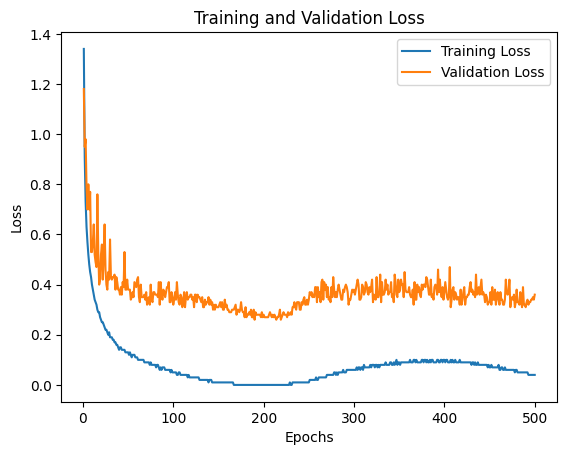

In [ ]:
# Load the training and validation loss dictionaries
train_loss = load(open('train_loss.pkl', 'rb'))
val_loss = load(open('val_loss.pkl', 'rb'))
 
# Retrieve each dictionary's values
train_loss_values = train_loss.values()
val_loss_values = val_loss.values()
 
# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, 501)
 
# Plot and label the training and validation loss values
plt.plot(epochs, train_loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(arange(0, 501, 100))
 
# Display the plot
plt.legend(loc='best')
plt.show()

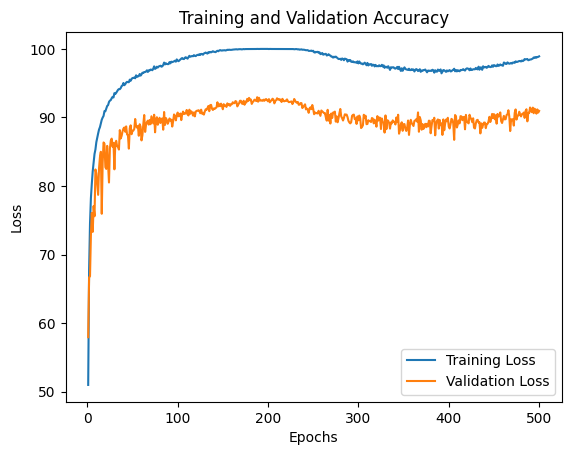

In [ ]:
# Load the training and validation loss dictionaries
train_acc = load(open('train_acc.pkl','rb'))
val_acc = load(open('val_acc.pkl','rb'))
 
# Retrieve each dictionary's values
train_acc_values = train_acc.values()
val_acc_values = val_acc.values()
 
# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, 501)
 
# Plot and label the training and validation loss values
plt.plot(epochs, train_acc_values, label='Training Loss')
plt.plot(epochs, val_acc_values, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(arange(0, 501, 100))
 
# Display the plot
plt.legend(loc='best')
plt.show()